In [44]:
## main
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from PIL import Image

## skelarn -- preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector

## skelarn -- models
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

## sklearn -- metrics
from sklearn.metrics import f1_score, confusion_matrix

In [45]:
## --------------------- Data Preparation ---------------------------- ##
## Read the Dataset
df = pd.read_csv('D:\mlops\CML\dataset.csv')
## Drop first 3 features
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
## Filtering using Age Feature using threshold
df.drop(index=df[df['Age']>80].index.tolist(), axis=0, inplace=True)  

## To features and target
x = df.drop(columns=['Exited'], axis=1)
y = df['Exited']
## Split to train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)

In [46]:
## --------------------- Data Processing ---------------------------- ##
num_col=['CreditScore','Age','Balance','EstimatedSalary']
cat_col=['Geography','Gender']
ready_col=list(set(x_train.columns.tolist())-set(num_col)-set(cat_col))
## Numerical Pipeline
num_pipeline=Pipeline([
    ('selector',DataFrameSelector(num_col)),
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
## Categorical Pipeline
cat_pipeline=Pipeline([
    ('selector',DataFrameSelector(cat_col)),
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('one',OneHotEncoder())
])
## Ready Pipeline
ready_pipeline=Pipeline([
    ('selector',DataFrameSelector(ready_col)),
    ('imputer',SimpleImputer(strategy='most_frequent'))
])
## Full Pipeline
afull_pipeline=FeatureUnion(transformer_list=[
    ('num',num_pipeline),
    ('cat',cat_pipeline),
    ('ready',ready_pipeline)])
## Fit and Transform the training data
x_train_prepared=afull_pipeline.fit_transform(x_train)
x_test_prepared=afull_pipeline.transform(x_test)

In [47]:
## --------------------- Impalancing ---------------------------- ##

## 1. use algorithm without taking the effect of imbalancing

## 2. prepare class_weights for solving imbalance dataset
vals_count=1-(np.bincount(y_train)/len(y_train))
vals_count=vals_count/np.sum(vals_count) ## normalizing
dict_wieght={}
for i in range(0,2):
    dict_wieght[i]=vals_count[i]
## 3. Using SMOTE for over sampling
over=SMOTE(sampling_strategy=0.7)
x_train_resample, y_train_resample=over.fit_resample(x_train_prepared, y_train)

In [48]:
## --------------------- Modeling ---------------------------- ##
## Clear metrics.txt file at the beginning
with open('metrics.txt', 'w') as f:
    pass

In [49]:
def train_model(x_train,y_train,plot_name='',class_weight=None):
    """ A function to train model given the required train data """
    global clf_name
    clf=RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight=class_weight)
    clf.fit(x_train,y_train)
    y_pred_train=clf.predict(x_train)
    y_pred_test=clf.predict(x_test_prepared)
    f1_train=f1_score(y_train,y_pred_train)
    f1_test=f1_score(y_test,y_pred_test)
    clf_name=clf.__class__.__name__
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cbar=False, fmt='.2f', cmap='Blues')
    plt.title(f'{plot_name}')
    plt.xticks(ticks=np.arange(2) + 0.5, labels=[False, True])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=[False, True])

    ## Save the plot locally
    plt.savefig(f'{plot_name}.png', bbox_inches='tight', dpi=300)
    plt.close()
    ## Write scores to a file
    with open('metrics.txt', 'a') as f:
        f.write(f'{clf_name}{plot_name}\n')
        f.write(f'F1-Score Train: {f1_train*100:.2f}%\n')
        f.write(f'F1-Score test: {f1_test*100:.2f}%\n')
        f.write('------'*10+'\n')
    return True
  


In [50]:
## 1. without considering the imabalancing data
train_model(x_train=x_train_prepared, y_train=y_train, plot_name='without-imbalance', class_weight=None)

## 2. with considering the imabalancing data using class_weights
train_model(x_train=x_train_prepared, y_train=y_train, plot_name='with-class-weights', class_weight=dict_wieght)

## 3. with considering the imabalancing data using oversampled data (SMOTE)
train_model(x_train=x_train_resample, y_train=y_train_resample, plot_name=f'with-SMOTE', class_weight=None)

True

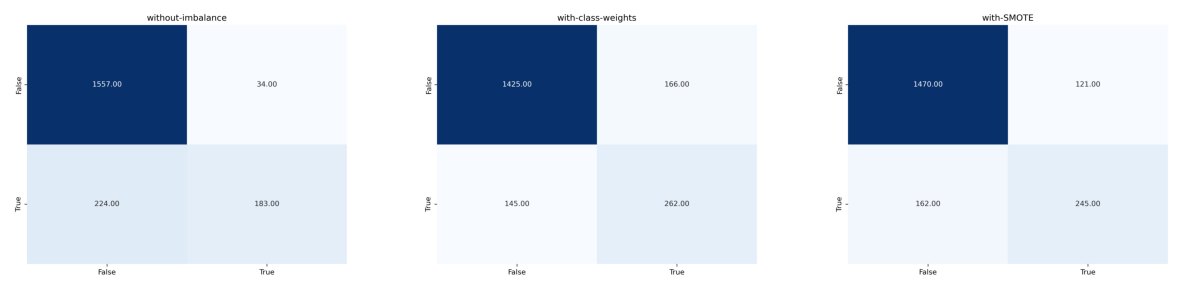

In [51]:
## Combine all conf matrix in one
confusion_matrix_paths = [f'./without-imbalance.png', f'./with-class-weights.png', f'./with-SMOTE.png']

## Load and plot each confusion matrix
plt.figure(figsize=(15, 5))  # Adjust figure size as needed
for i, path in enumerate(confusion_matrix_paths, 1):
    img = Image.open(path)
    plt.subplot(1, len(confusion_matrix_paths), i)
    plt.imshow(img)
    plt.axis('off')  # Disable axis for cleaner visualization

In [52]:
## Save combined plot locally
plt.suptitle(clf_name, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'conf_matrix.png', bbox_inches='tight', dpi=300)


<Figure size 640x480 with 0 Axes>

In [53]:
## Delete old image files
for path in confusion_matrix_paths:
    os.remove(path)